In [1]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import cv2
import utils

import sys
sys.path.append('../ZoeDepth')
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image

%matplotlib inline

In [2]:
zoe = torch.hub.load("../ZoeDepth", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in /Users/coltersirlin/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [3]:
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w" #@param {type:"string"}
# img = get_image_from_url(img_url)
image_path = "depth.jpg"  # Change to your image path
img = Image.open(image_path)
depth = zoe.infer_pil(img)
img = np.array(img)

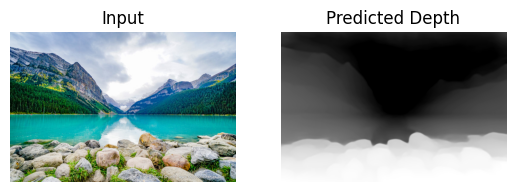

In [4]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

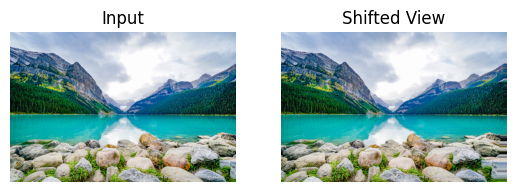

In [5]:
# compute shifted image
warped_image = utils.compute_right_eye(img, depth, 60, shift=0.063)

fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, warped_image], ['Input', 'Shifted View']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

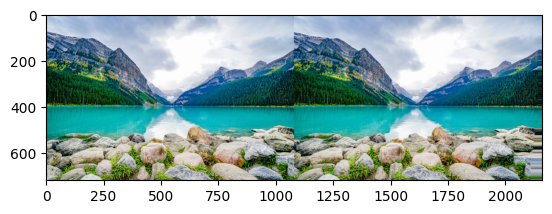

In [6]:
# look closely to get the magic eye/3D effect
img_and_warped = np.hstack((img, warped_image))
plt.imshow(img_and_warped)
# im = Image.fromarray(img_and_warped)
# im.save("../output.jpeg")

In [7]:
### pulse2percept time ###
scoreboard = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
scoreboard.build()

ScoreboardModel(engine=None, grid_type='rectangular', 
                n_gray=None, n_jobs=1, n_threads=10, 
                ndim=[2], noise=None, rho=100, 
                scheduler='threading', 
                spatial=ScoreboardSpatial, temporal=None, 
                thresh_percept=0, verbose=True, 
                vfmap=Watson2014Map(ndim=2), 
                xrange=(-12, 12), xystep=0.1, 
                yrange=(-12, 12))

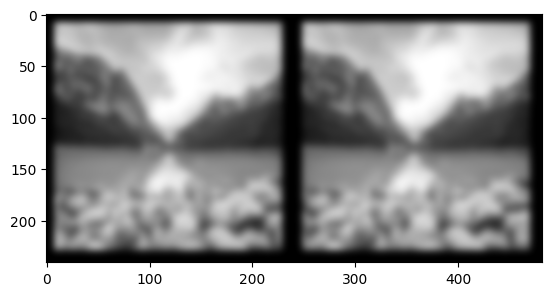

In [8]:
big_prosthetic = utils.get_big_prosthesis()
big_percept_left = utils.get_percept_data_from_image(img, scoreboard, big_prosthetic)
big_percept_right = utils.get_percept_data_from_image(warped_image, scoreboard, big_prosthetic)

# idealized percepts still have the effect!
percept_side_by_side = np.hstack((big_percept_left, big_percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

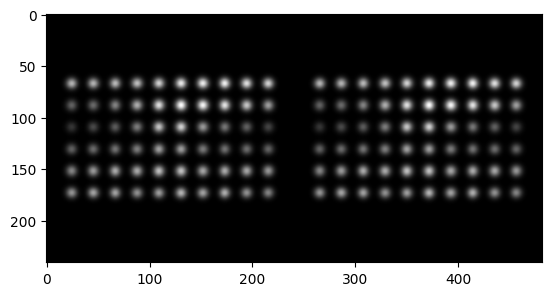

In [9]:
# now try argus II
argus = p2p.implants.ArgusII()
argus_percept_left = utils.get_percept_data_from_image(img, scoreboard, argus)
argus_percept_right = utils.get_percept_data_from_image(img, scoreboard, argus)

# resulting view is basically useless
percept_side_by_side = np.hstack((argus_percept_left, argus_percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

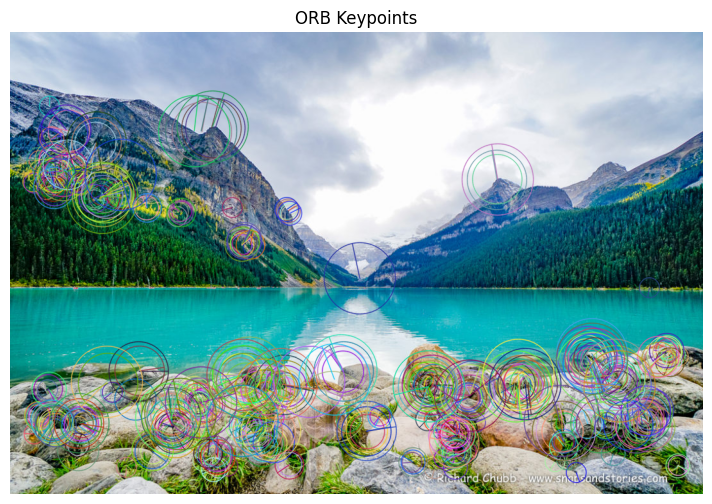

In [10]:
kp_left, kp_right, img_keypoints = utils.get_keypoint_positions(img, depth, \
                                                 num_to_include=100, fov=60, \
                                                 shift=0.063)

# Display the image with keypoints
plt.figure(figsize=(10, 6))
plt.imshow(img_keypoints, cmap='gray')
plt.title("ORB Keypoints")
plt.axis("off")
plt.show()

(720, 1080, 3)


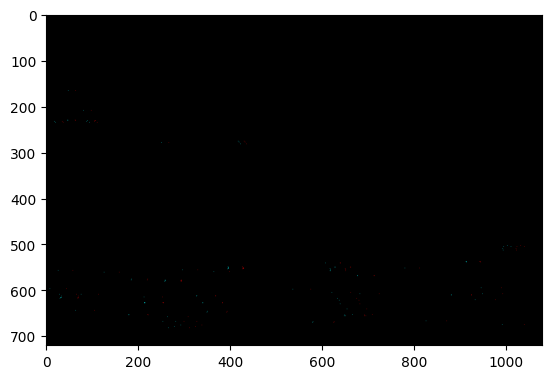

In [11]:
empty = np.zeros(img.shape)
print(img.shape)
for (j, i) in kp_left:
    empty[int(i)][int(j)] = [1, 0, 0]
for (j, i) in kp_right:
    empty[int(i)][int(j)] = [0, 1, 1]
plt.imshow(empty)

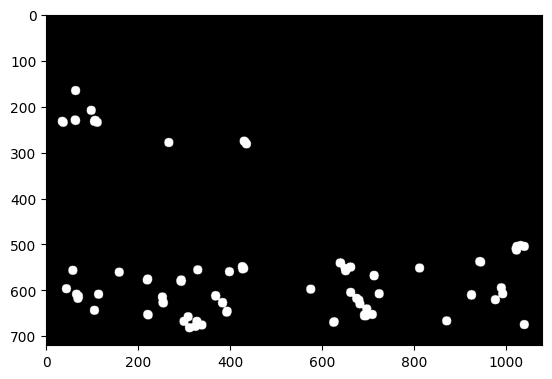

In [12]:
kp_left_img = utils.get_keypoint_image(img.shape, kp_left)
plt.imshow(kp_left_img)

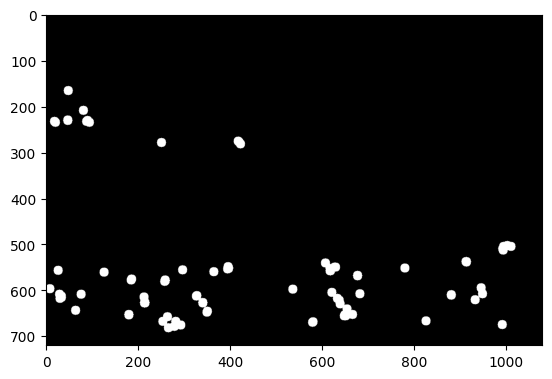

In [13]:
kp_right_img = utils.get_keypoint_image(img.shape, kp_right)
plt.imshow(kp_right_img)

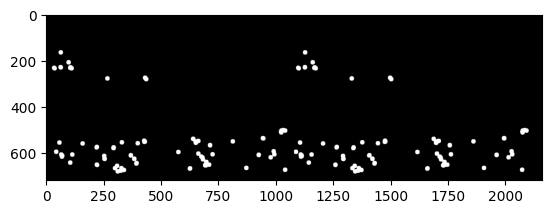

In [14]:
percept_side_by_side = np.hstack((kp_left_img, kp_right_img))
plt.imshow(percept_side_by_side, cmap='gray')

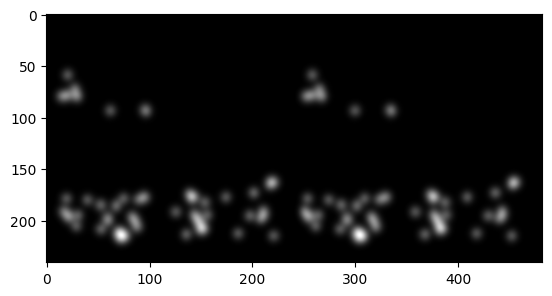

In [15]:
# map these key points onto electodes
# dumb way: use the image as a stimulus
# smart way: use the keypoints to trigger particular electrodes
# try both of these with big_prosthetic and argusII. 

# image stim big prosthetic - sort of works
keypoints_big_left = utils.get_percept_data_from_image(kp_left_img, scoreboard, big_prosthetic)
keypoints_big_right = utils.get_percept_data_from_image(kp_right_img, scoreboard, big_prosthetic)
percept_side_by_side = np.hstack((keypoints_big_left, keypoints_big_right))
plt.imshow(percept_side_by_side, cmap='gray')

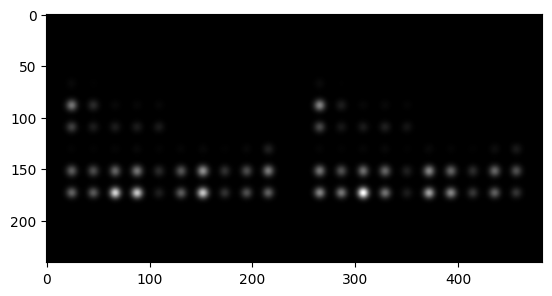

In [16]:
# image stim argus II - I don't think it really works
keypoints_argus_left = utils.get_percept_data_from_image(kp_left_img, scoreboard, argus)
keypoints_argus_right = utils.get_percept_data_from_image(kp_right_img, scoreboard, argus)
percept_side_by_side = np.hstack((keypoints_argus_left, keypoints_argus_right))
plt.imshow(percept_side_by_side, cmap='gray')

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

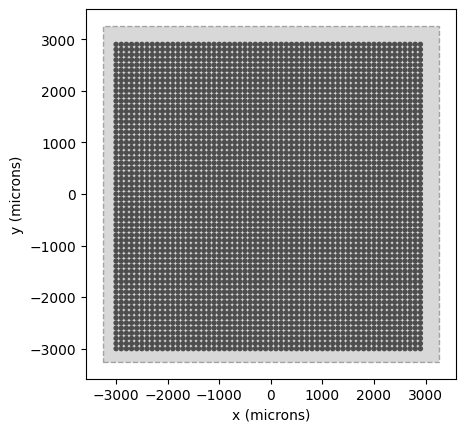

In [17]:
scoreboard.plot()
big_prosthetic.plot()

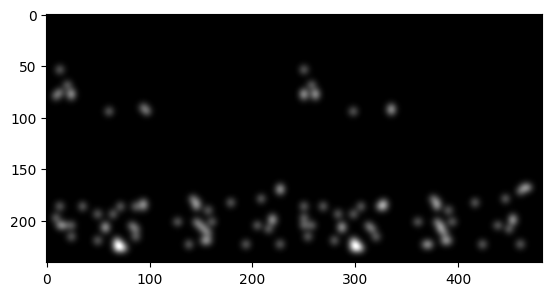

In [18]:
big_prosthetic.stim = utils.get_stim_from_key_points(big_prosthetic, kp_left, img.shape[0:2])
keypoints_smart_big_left = scoreboard.predict_percept(big_prosthetic).data
big_prosthetic.stim = utils.get_stim_from_key_points(big_prosthetic, kp_right, img.shape[0:2])
keypoints_smart_big_right = scoreboard.predict_percept(big_prosthetic).data
percept_side_by_side = np.hstack((keypoints_smart_big_left, keypoints_smart_big_right))
plt.imshow(percept_side_by_side, cmap='gray')

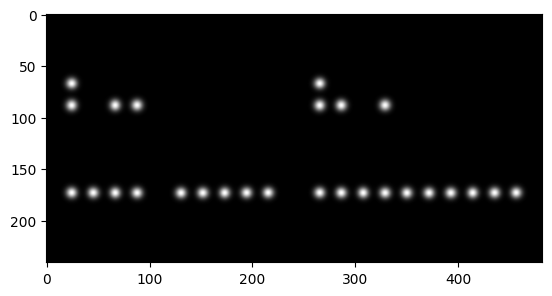

In [19]:
argus.stim = utils.get_stim_from_key_points(argus, kp_left, img.shape[0:2])
keypoints_smart_argus_left = scoreboard.predict_percept(argus).data
argus.stim = utils.get_stim_from_key_points(argus, kp_right, img.shape[0:2])
keypoints_smart_argus_right = scoreboard.predict_percept(argus).data
percept_side_by_side = np.hstack((keypoints_smart_argus_left, keypoints_smart_argus_right))
plt.imshow(percept_side_by_side, cmap='gray')